In [1]:
from utilities import *
from models import *

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import confusion_matrix, accuracy_score

import optuna

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import ListedColormap

import json

### 1 - Load features matrix (from files)

In [2]:
#dataset_train = load_dataset("Train")
#dataset_test = load_dataset("Test", test_from_file=False) # test_from_file=True if you already run once before
#X, y = create_features_matrix(dataset_train,category=True,save=False)
#X_test = create_features_matrix(dataset_test,category=False, save=False)

X = np.load("saves/train_features_Khened.npy")
X_test = np.load("saves/test_features_Khened.npy")
y = np.load("saves/categories.npy")

y = y.astype(np.int64)
print(f"Number of features: {X.shape[1]}")

Number of features: 20


In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [4]:
TRAIN = False #If True, search for the best hyperparameters : can take a long time. Else, load the best hyperparameters from the json file

### 2 - Hyperparameters search for each classifier of stage 1

In [5]:
svm_params_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.0001],
    'kernel': ['rbf']
}

rf_params_grid = {
    "n_estimators": [1000],
    "max_depth": [None],
    "min_samples_split": randint(5, 30),
    "min_samples_leaf": randint(5, 30),
    "max_features": ["sqrt", "log2", None],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False]
}

gnb_params_grid = {
    "var_smoothing": [1e-9, 1e-10,1e-8]
}

xgb_params_grid = {
    "n_estimators": [1000],
    "max_depth": [None],
    "learning_rate": [0.01, 0.1],
    "min_child_weight": randint(1, 10),
    "max_leaves": randint(1, 10),
    "subsample": [0.8, 1.0],
    "random_state": [0],
}

In [6]:
clfs = []
if TRAIN:
    for clf, params, name in zip([SVC(random_state=0,probability=True), RandomForestClassifier(random_state=0), GaussianNB(), XGBClassifier()], [svm_params_grid, rf_params_grid, gnb_params_grid, xgb_params_grid], ["svm", "rf", "gnb", "xgb"]):
        print(f"Training {name}")
        if name == "rf" or name == "xgb":
            grid = RandomizedSearchCV(clf, params, n_iter=50, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
        else:
            grid = GridSearchCV(clf, params, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1,)
        grid.fit(X, y)
        print(f"Best parameters: {grid.best_params_}")
        print(f"Best score: {grid.best_score_}")
        clfs.append((name,grid.best_estimator_))
        print(f"Done {name}")
        print("\n")

else:
    svm = SVC(**json.load(open("saves/svm_params.json", "r")))
    rf = RandomForestClassifier(**json.load(open("saves/rf_params.json", "r")))
    gnb = GaussianNB(**json.load(open("saves/gnb_params.json", "r")))
    xgb = XGBClassifier(**json.load(open("saves/xgb_params.json", "r")))
    clfs = [('svm', svm), ('rf', rf), ('gnb', gnb), ('xgb', xgb)]

In [7]:
if TRAIN:

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda t:objective_mlp_opti(t,X=X,y=y), n_trials=10)

    best_params = study.best_params
    best_params["hidden_layer_sizes"] = tuple(map(int, best_params["hidden_layer_sizes"].split("-")))
    
    print("Best params:", best_params)
    print(f"Best accuracy: {study.best_value:.4f}")
    
    best_mlp = MLPClassifier(**best_params, max_iter=1000, random_state=0)

    if len(clfs) == 3:
        clfs.append(('mlp', best_mlp))
    else:
        clfs[3] = ('mlp', best_mlp)

else:
    best_mlp = MLPClassifier(**json.load(open("saves/mlp_params.json", "r")))
    clfs.append(('mlp', best_mlp))

### 3 - Final scores for each classifier

In [8]:
for clf in clfs:
    cross_score = cross_val_score(clf[1], X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
    print(f"{clf[0]}: {cross_score.mean():.4f} +/- {cross_score.std():.4f}")

svm: 0.9600 +/- 0.0490
rf: 0.9500 +/- 0.0548
gnb: 0.9500 +/- 0.0632
xgb: 0.9400 +/- 0.0583
mlp: 0.9400 +/- 0.0583


### 4 - Combining classifiers into one VotingClassifier

In [9]:
eclf_soft = VotingClassifier(estimators=clfs, voting='soft')
eclf_hard = VotingClassifier(estimators=clfs, voting='hard')
scores_soft = cross_val_score(eclf_soft, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
scores_hard = cross_val_score(eclf_hard, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
print(f"Cross-validation Accuracy of soft voting :  {scores_soft.mean():.4f} +/- {scores_soft.std():.4f}")
print(f"Cross-validation Accuracy of hard voting :  {scores_hard.mean():.4f} +/- {scores_hard.std():.4f}")

Cross-validation Accuracy of soft voting :  0.9700 +/- 0.0400
Cross-validation Accuracy of hard voting :  0.9800 +/- 0.0400


Text(0.5, 1.0, 'Confusion Matrix')

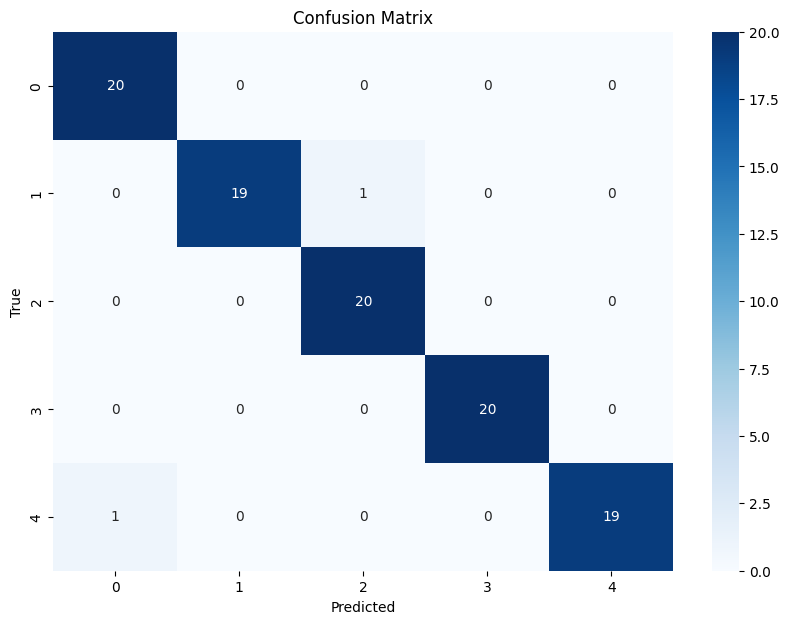

In [10]:
y_pred_soft = cross_val_predict(eclf_hard, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
cm = confusion_matrix(y, y_pred_soft)
    
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y), yticklabels=set(y))
#sns.heatmap(cms[1:3, 1:3, 0], annot=True, cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

### 5 - Check features importance with RF and plot decision surface

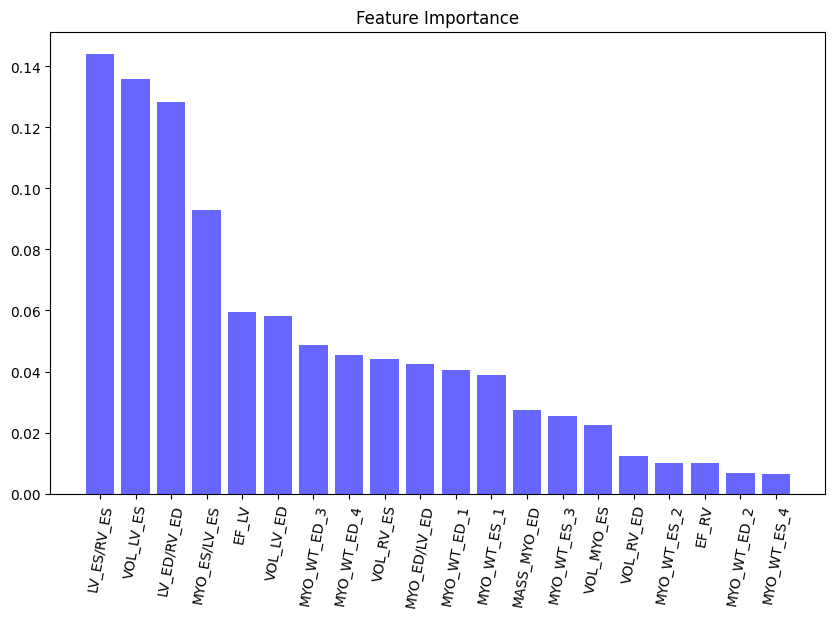

In [15]:
rf = clfs[1][1]

names_features = [
        "VOL_LV_ED", "VOL_RV_ED", "VOL_LV_ES", "VOL_RV_ES", "VOL_MYO_ES",
        "MASS_MYO_ED", "EF_LV", "EF_RV", "LV_ED/RV_ED", "LV_ES/RV_ES",
        "MYO_ES/LV_ES", "MYO_ED/LV_ED", "MYO_WT_ED_1", "MYO_WT_ED_2",
        "MYO_WT_ED_3", "MYO_WT_ED_4", "MYO_WT_ES_1", "MYO_WT_ES_2",
        "MYO_WT_ES_3", "MYO_WT_ES_4"
    ]

rf.fit(X, y)

importances = rf.feature_importances_

index = np.argsort(importances)[::-1]
names_features = np.array(names_features)

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center", color="blue", alpha=0.6)
#plt.xticks(range(len(importances)),index, rotation=90)
plt.xticks(range(len(importances)),names_features[index], rotation=80)

plt.show()

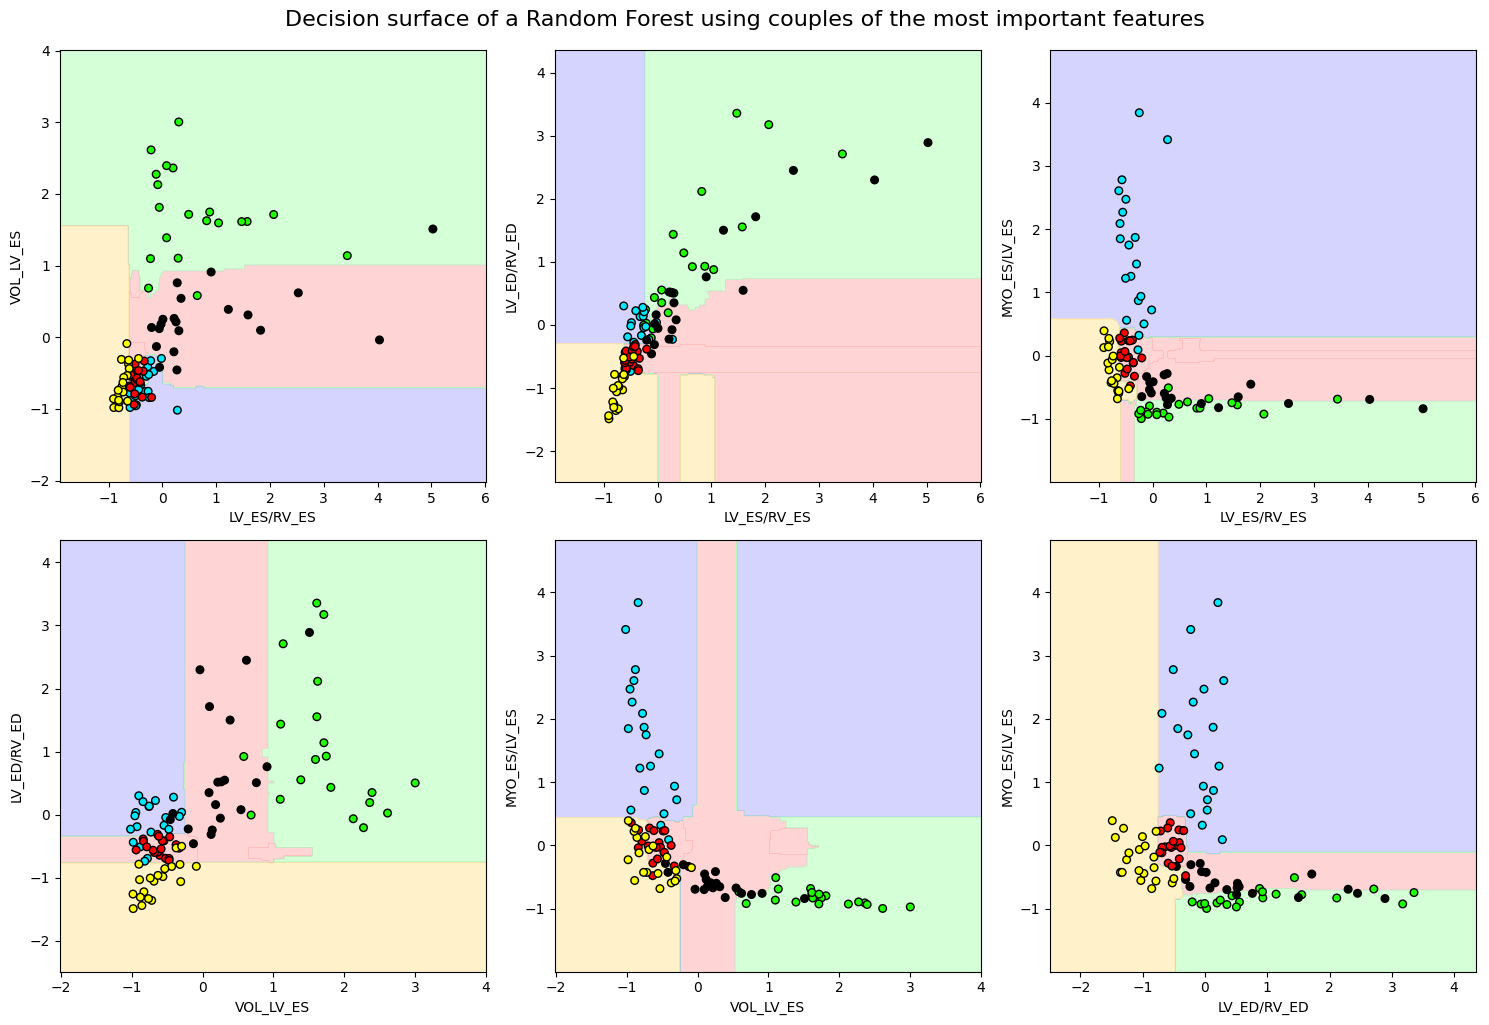

In [16]:
pairs = [(9,2), (9,8), (9,10), (2,8), (2,10), (8,10)]
#class_names = ['NOR', 'MINF', 'DCM', 'HCM', 'ARV']
cmap_background = ListedColormap(['#FFAAAA', '#D9D9D9', '#AAFFB0', '#AAAAFF', '#FFE699'])
cmap_points = ListedColormap(['#FF0000', '#000000', '#1FFF00', '#00E8FF', '#FBFF00'])

plt.figure(figsize=(15,10))
for idx, (i1, i2) in enumerate(pairs):
    X_pair = X[:, [i1, i2]]
    y_pair = y

    rf.fit(X_pair, y_pair)

    x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
    y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = rf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot(2, 3, idx + 1)
    plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.5)
    plt.scatter(X_pair[:, 0], X_pair[:, 1], c=y_pair, cmap=cmap_points, edgecolor='k', s=30)

    #plt.xlabel(f"Feature {i1}")
    #plt.ylabel(f"Feature {i2}")
    plt.xlabel(names_features[i1])
    plt.ylabel(names_features[i2])

plt.tight_layout()
plt.suptitle("Decision surface of a Random Forest using couples of the most important features", y=1.02, fontsize=16)
plt.show()


### 6 - Expert MLP architecture search

In [13]:
mask = (y == 1) | (y == 2)
X_expert = X[mask][:, 16:20].astype(np.float32)
y_expert = y[mask].astype(np.int64)

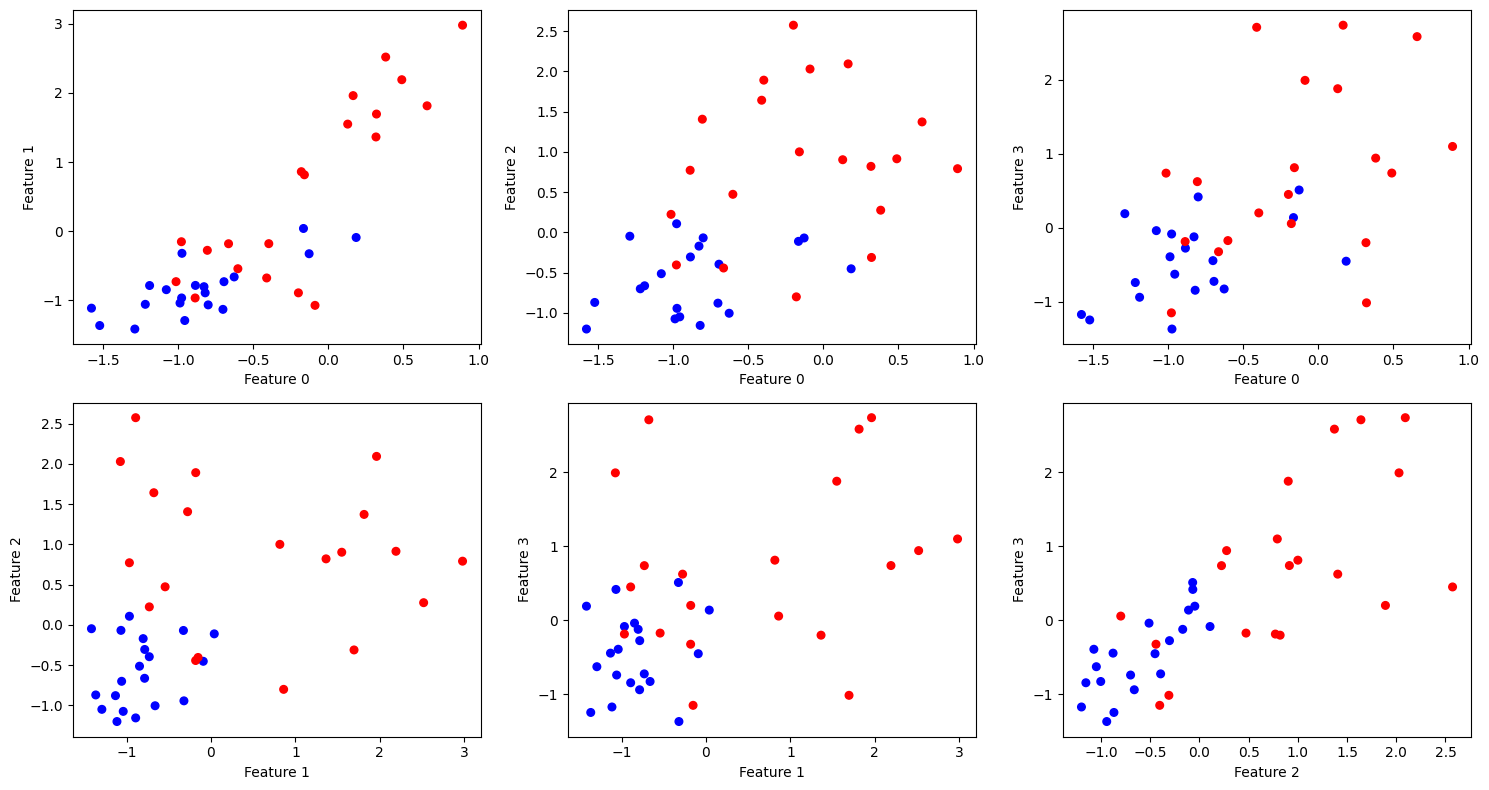

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
inds = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
for i,axx in enumerate(ax.flatten()):
    if i >= len(inds):
        break
    ind1, ind2 = inds[i]
    #axx.set_title(f"Feature {ind1} vs Feature {ind2}")
    #sns.kdeplot(x=X_expert[:, ind1], y=X_expert[:, ind2], hue=y_expert, fill=True, ax=axx, levels=20)
    axx.scatter(X_expert[:, ind1], X_expert[:, ind2], c=y_expert, s=30, cmap=matplotlib.colors.ListedColormap(['red', 'blue']))

    axx.set_xlabel(f"Feature {ind1}")
    axx.set_ylabel(f"Feature {ind2}")
        
plt.tight_layout()

#### a) MLP from scikit-learn

In [15]:
if TRAIN:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda t:objective_mlp_opti(t,X=X_expert,y=y_expert), n_trials=10)

    print("Best params:", study.best_params)
    print(f"Best accuracy: {study.best_value:.4f}")

    best_params = study.best_params
    best_params["hidden_layer_sizes"] = tuple(map(int, best_params["hidden_layer_sizes"].split("-")))
    mlp_expert1 = MLPClassifier(**best_params, max_iter=1000, random_state=0)
    
else:
    mlp_expert1 = MLPClassifier(**json.load(open("saves/mlp_expert1_params.json", "r")))
    
mlp_expert1.fit(X_expert, y_expert)
cross_score = cross_val_score(mlp_expert1, X_expert, y_expert, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
print("Best MLP expert score:", cross_score.mean(), "+/-", cross_score.std())

Best MLP expert score: 0.975 +/- 0.049999999999999996


#### b) MLP from Pytorch

In [16]:
if TRAIN:
    torch.manual_seed(0)
    np.random.seed(0)
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda t:objective_expert(t,X_expert=X_expert,y_expert=y_expert), n_trials=30)

    print("Best parameters found:")
    print(study.best_params)
    print(f"Best cross-val accuracy: {study.best_value:.4f}")
    mlp_expert2 = MLP(input_dim=4, hidden_dim=study.best_params["hidden_dim"], n_layers=study.best_params["n_layers"], dropout=study.best_params["dropout"], output_dim=2,lr=study.best_params["lr"], weight_decay=study.best_params["weight_decay"], epochs=800, verbose=False)
    mlp_expert2 = mlp_expert2.fit(X_expert,y_expert)

else:
    mlp2_params = json.load(open("saves/mlp_expert2_params.json", "r"))
    mlp_expert2 = MLP(input_dim=4, hidden_dim=mlp2_params["hidden_dim"], n_layers=mlp2_params["n_layers"], dropout=mlp2_params["dropout"], output_dim=2,lr=mlp2_params["lr"], weight_decay=mlp2_params["weight_decay"], epochs=mlp2_params["epochs"], verbose=False)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #have to do it by hand because not compatible with cross_val_score
    val_scores = []
    for train_idx, val_idx in skf.split(X_expert, y_expert):
        X_train, X_val = X_expert[train_idx], X_expert[val_idx]
        y_train, y_val = y_expert[train_idx], y_expert[val_idx]

        mlp_expert2.fit(X_train, y_train)
        y_pred = mlp_expert2.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        val_scores.append(acc)
    print(f"Accuracy of the best MLP expert: {np.mean(val_scores):.4f} +/- {np.std(val_scores):.4f}")
    mlp_expert2.load_state_dict(torch.load("saves/mlp_expert2.pth", weights_only=True))


Accuracy of the best MLP expert: 0.9500 +/- 0.0612


#### c) MLP Bagging

In [17]:
mlp2_params = json.load(open("saves/mlp_expert2_params.json", "r")) #we use the same parameters as the one used for mlp_expert2

mlp_expert3 = BaggedMLP(
    n_models=50,
    input_dim=4,
    hidden_dim=mlp2_params["hidden_dim"],
    n_layers=mlp2_params["n_layers"],
    dropout=mlp2_params["dropout"],
    lr=mlp2_params["lr"],
    weight_decay=mlp2_params["weight_decay"],
    feature_fraction=2/3,
    sample_fraction=0.75,
    epochs=mlp2_params["epochs"]
)

In [18]:
mlp_expert3 = mlp_expert3.fit(X_expert,y_expert) #we fit in all cases (tricky to do otherwise)

### 7 - Final prediction and submission (Combining stage 1 and 2 into one prediction function)

In [19]:
y_pred0 = predictions(X, y, X_test, clfs, mlp_expert_fitted=None, voting="hard")
y_pred1 = predictions(X, y, X_test, clfs, mlp_expert_fitted=mlp_expert1, voting="hard")
y_pred2 = predictions(X, y, X_test, clfs, mlp_expert_fitted=mlp_expert2, voting="hard")
y_pred3 = predictions(X, y, X_test, clfs, mlp_expert_fitted=mlp_expert3, voting="hard")

In [20]:
# See where the predictions differ
index = []
for i in range(len(y_pred0)):
    if y_pred0[i] != y_pred1[i]:
        index.append(i)
    if y_pred0[i] != y_pred2[i]:
        index.append(i)
    if y_pred0[i] != y_pred3[i]:
        index.append(i)
    if y_pred1[i] != y_pred2[i]:
        index.append(i)
    if y_pred1[i] != y_pred3[i]:
        index.append(i)
    if y_pred2[i] != y_pred3[i]:
        index.append(i)
        
print(f"Number of different predictions: {len(set(index))}")
print(f"Index of different predictions: {set(index)}\n")
print(f"Different predictions between y_pred0 and y_pred1: {np.sum(y_pred0 != y_pred1)}")
print(f"Different predictions between y_pred1 and y_pred2: {np.sum(y_pred1 != y_pred2)}")
print(f"Different predictions between y_pred1 and y_pred3: {np.sum(y_pred1 != y_pred3)}")
print(f"Different predictions between y_pred0 and y_pred3: {np.sum(y_pred0 != y_pred3)}")

Number of different predictions: 3
Index of different predictions: {41, 34, 15}

Different predictions between y_pred0 and y_pred1: 1
Different predictions between y_pred1 and y_pred2: 0
Different predictions between y_pred1 and y_pred3: 2
Different predictions between y_pred0 and y_pred3: 3


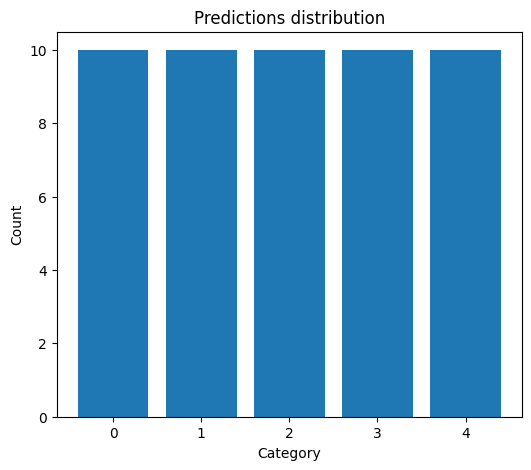

Submission file submissions/submission_phase_2_MLP_bagging.csv created


In [23]:
submission(y_pred3, "submissions/submission_phase_2_MLP_bagging", plot=True)